<a href="https://colab.research.google.com/github/step-cheng/mnist_from_scratch/blob/main/Updated_mnist_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
from os.path import join
import matplotlib.pyplot as plt
from keras.datasets import mnist

In [2]:
def shuffle(x,y):
  pattern = np.random.permutation(y.size)
  x, y = x[pattern,:,:], y[pattern]
  return x, y

def one_hot_encode(labels):
  one_hot = np.zeros((10,labels.size))
  one_hot[labels, range(labels.size)] = 1
  return one_hot

# normalize by dividing by max value
def normalize(data):
  data = data * (1 / 255)
  return data

def split(img_data, label_data, r):
  assert img_data.shape[1] == label_data.shape[1]
  assert (img_data.shape[1] * r) % 1 == 0
  div = int(img_data.shape[1]*r)
  return img_data[:,:div], label_data[:,:div], img_data[:,div:], label_data[:,div:]


In [56]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# set up training and validation data
x_train, y_train = shuffle(x_train, y_train)
train_onehotY = one_hot_encode(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],784)).T
norm_x_train = normalize(x_train)

assert norm_x_train.shape == (784,60000)
assert train_onehotY.shape == (10,60000)

r = 5/6
train_imgs, train_labels, val_imgs, val_labels = split(norm_x_train, train_onehotY, r)

# set up test data
x_test, y_test = shuffle(x_test, y_test)
test_labels = one_hot_encode(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], 784)).T
test_imgs = normalize(x_test)

assert test_imgs.shape == (784, 10000)
assert test_labels.shape == (10, 10000)

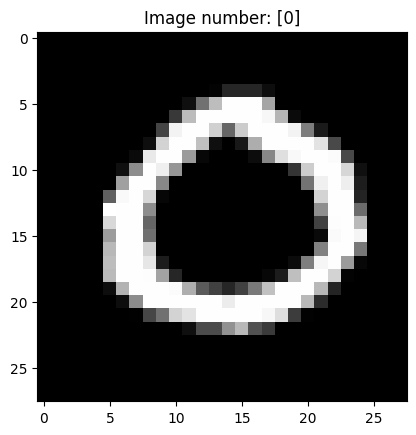

In [57]:
def show_image(img, label):
    img = np.reshape(img.T, (28,28))
    num = np.where(label == 1)
    plt.figure()
    plt.title(f'Image number: {num[0]}')
    plt.imshow(img, cmap=plt.cm.gray)

# show_image(train_imgs[:,9000],train_labels[:,9000])
show_image(test_imgs[:,9000],test_labels[:,9000])


In [5]:
def initialize(dims):
  params = {}
  for i in range(1, len(dims)):
      params['W' + str(i)] = np.random.randn(dims[i], dims[i-1]) * np.sqrt(1/(dims[i]))
      params['b' + str(i)] = np.random.randn(dims[i], 1) * np.sqrt(1/dims[i])
  return params


In [21]:
def relu(Z):
  return np.maximum(Z,0)

def softmax(Z):
  Z_ = Z - np.max(Z, axis = 0, keepdims = True)
  A = np.exp(Z_) / np.sum(np.exp(Z_), axis = 0, keepdims = True)
  return A

def forward_pass(X, params):
  L = len(params)//2

  forward = {}
  forward['A0'] = X

  for i in range(1,L):
    forward['Z'+str(i)] = np.dot(params['W'+str(i)], forward['A'+str(i-1)]) + params['b'+str(i)]
    forward['A'+str(i)] = relu(forward['Z'+str(i)])

  forward['Z'+str(L)] = np.dot(params['W'+str(L)], forward['A'+str(L-1)]) + params['b'+str(L)]
  forward['A'+str(L)] = softmax(forward['Z'+str(L)])


  return forward


In [7]:
def accuracy(A, Y):
  assert A.shape == Y.shape
  pred = np.zeros_like(A)
  pred[np.argmax(A, axis = 0), range(A.shape[1])] = 1
  acc = np.count_nonzero(pred + Y == 2) / Y.shape[1]
  return acc

In [20]:
def relu_deriv(A):
  return A > 0

def softmax_crossentropy_deriv(A, Y):
  return A - Y

def back_pass(forward, params, Y):
  L = len(params) //2

  grads = {}

  # cross-entropy loss is calculated by averaging the loss over the sample size, thus the upstream gradient is 1/sample size
  N = Y.shape[1]

  # grads['dZ'+str(L)] = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  dZ = 1 * softmax_crossentropy_deriv(forward['A'+str(L)], Y)
  # grads['dW'+str(L)] = np.dot(dZ, forward['A'+str(L-1)].T)
  grads['dW'+str(L)] = 1/N * np.dot(dZ, forward['A'+str(L-1)].T)
  assert grads['dW'+str(L)].shape == params['W'+str(L)].shape
  grads['db'+str(L)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
  assert grads['db'+str(L)].shape == params['b'+str(L)].shape


  for i in range(L-1,0,-1):
    # dA_i+1 = W_i+1.T * dZ
    # grads['dZ'+str(i)] = np.multiply(np.dot(params['W'+str(i+1)].T, grads['dZ'+str(i+1)]), relu_deriv(forward['Z'+str(i)]))
    dZ = np.dot(params['W'+str(i+1)].T, dZ) * relu_deriv(forward['Z'+str(i)])
    # grads['dW'+str(i)] = np.dot(dZ, forward['A'+str(i-1)].T)
    grads['dW'+str(i)] = 1/N * np.dot(dZ, forward['A'+str(i-1)].T)
    assert grads['dW'+str(L)].shape == params['W'+str(L)].shape
    grads['db'+str(i)] = 1/N * np.sum(dZ, axis = 1, keepdims=True)
    assert grads['db'+str(i)].shape == params['b'+str(i)].shape

  return grads


In [9]:
def learn(grads, params, rate):
  L= len(params)//2

  new_params = {}
  for i in range(1, L + 1):
    new_params['b'+str(i)] = params['b'+str(i)] - rate*grads['db'+str(i)]
    new_params['W'+str(i)] = params['W'+str(i)] - rate*grads['dW'+str(i)]

  return new_params

In [53]:
def model(img_data, label_data, num_batches, iterations = 1, rate = 0.01, dims = None, params = None, train = True):
  if params is None: params = initialize(dims)

  assert label_data.shape[1] % num_batches == 0
  batch_size = int(label_data.shape[1] / num_batches)

  L = len(params)//2
  accuracies = []

  # training data
  if train:
    for i in range(1, iterations+1):
      for j in range(num_batches):
        forward = forward_pass(img_data[:,j*batch_size:(j+1)*batch_size], params)

        acc = accuracy(forward['A'+str(L)], label_data[:,j*batch_size:(j+1)*batch_size])
        accuracies.append(acc)

        grads = back_pass(forward, params, label_data[:,j*batch_size:(j+1)*batch_size])
        params = learn(grads, params, rate)

      if i % 10 == 0: print(f'Accuracy at iteration {i}: {accuracies[i-1]}')

  # for validating and testing data
  else:
      for j in range(num_batches):
        forward = forward_pass(img_data[:,j*batch_size:(j+1)*batch_size], params)

        acc = accuracy(forward['A'+str(L)], label_data[:,j*batch_size:(j+1)*batch_size])
        accuracies.append(acc)

        # grads = back_pass(forward, params, label_data[:,j*batch_size:(j+1)*batch_size])
        # params = learn(grads, params, rate)
        print(f'Accuracy at iteration {j+1}: {accuracies[j]}')

  plt.figure()
  plt.title('Training Accuracy') if train else plt.title('Test Accuracy')
  plt.xlabel('Cycles')
  plt.ylabel('accuracy (%)')
  plt.plot(range(1,len(accuracies)+1), [100*a for a in accuracies], marker = '.')
  plt.show()

  return params


Accuracy at iteration 10: 0.49502
Accuracy at iteration 20: 0.67556
Accuracy at iteration 30: 0.75128
Accuracy at iteration 40: 0.78884
Accuracy at iteration 50: 0.8132
Accuracy at iteration 60: 0.8299
Accuracy at iteration 70: 0.84264
Accuracy at iteration 80: 0.8531
Accuracy at iteration 90: 0.86036
Accuracy at iteration 100: 0.86688
Accuracy at iteration 110: 0.87226
Accuracy at iteration 120: 0.87688
Accuracy at iteration 130: 0.88138
Accuracy at iteration 140: 0.88476
Accuracy at iteration 150: 0.88774
Accuracy at iteration 160: 0.8902
Accuracy at iteration 170: 0.89246
Accuracy at iteration 180: 0.89528
Accuracy at iteration 190: 0.89704
Accuracy at iteration 200: 0.89894
Accuracy at iteration 210: 0.90094
Accuracy at iteration 220: 0.90262
Accuracy at iteration 230: 0.9041
Accuracy at iteration 240: 0.90546
Accuracy at iteration 250: 0.90698
Accuracy at iteration 260: 0.90828
Accuracy at iteration 270: 0.90982
Accuracy at iteration 280: 0.91116
Accuracy at iteration 290: 0.91246

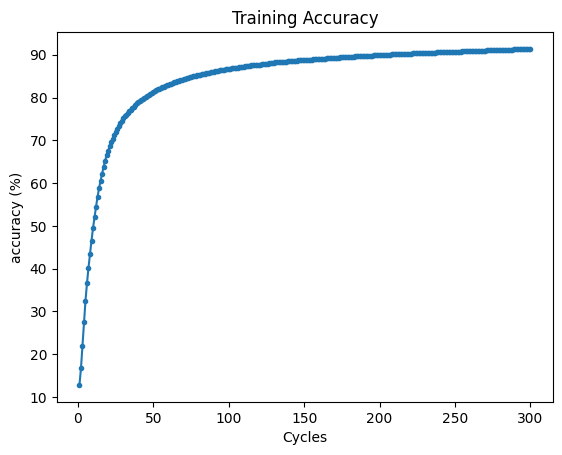

In [51]:
# train data

dimensions = [784, 128, 64, 10]
batches = 1
iterations = 300
rate = 0.05

params = model(train_imgs, train_labels, batches, iterations, rate, dimensions)

Accuracy at iteration 1: 0.9124


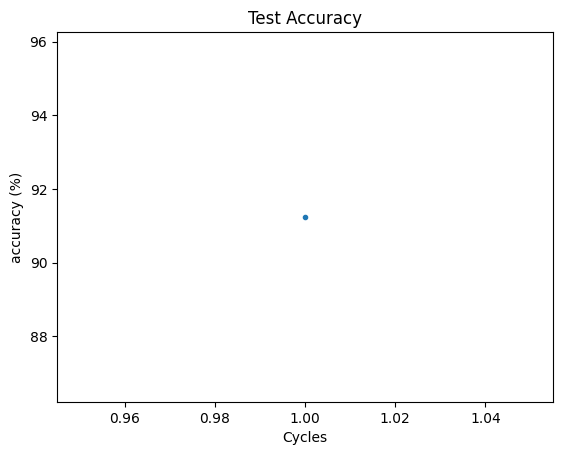

In [54]:
# validate data
batches = 1

params = model(val_imgs, val_labels, batches, params = params, train = False)

Accuracy at iteration 1: 0.9176


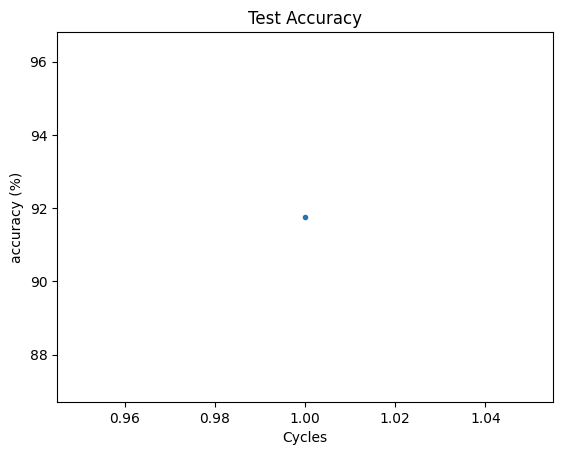

In [58]:
# test data
batches = 1

params = model(test_imgs, test_labels, batches, params = params, train = False)